<a href="https://colab.research.google.com/github/Simodiri/Vision-Perception/blob/main/Fast_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing modules
Import all necessary modules:

*  `numpy`: work with arrays
*  `tensorflow`: tensor operations
*  `tensorflow.keras`: creating neural networks
*  `pillow`: converting an image to a numpy array and viceversa`
*  `time`: calculating time of each iteration
*  `matplotlib`:displaying images and graphs in notebook
*  `request`,`base64`,`io`: downloading and loading images from url
* `os`: operating system level commands


In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import vgg19,resnet50
from tensorflow.keras.models import load_model,Model
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Download an implementation of resnet50 with other layers' names.

In [ ]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings
!pip install keras_applications
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Define utility functions

- *load_image* that is used to load image path and then convert it into a numpy array

In [ ]:
def load_image(image_path, dim=None, resize=False):
    img= Image.open(image_path)
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

- *load_url_image* which loads images from url and converts into a numpy array

In [ ]:
def load_url_image(url,dim=None,resize=False):
    img_request=requests.get(url)
    img= Image.open(BytesIO(img_request.content))
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

* *load_path_image* which loads images from a path (ex. google drive) and converts into a numpy array

In [ ]:
def load_path_image(path,dim=None,resize=False):
    img= Image.open(path)
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

- *array_to_img* converts an array to an image

In [ ]:
def array_to_img(array):
    array=np.array(array,dtype=np.uint8)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

- *show_image* plots a single image

In [ ]:
def show_image(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title=title

-*plot_images_grid* plots batches of images in grid

In [ ]:
 def plot_images_grid(images,num_rows=1):
    n=len(images)
    if n > 1:
        num_cols=np.ceil(n/num_rows)
        fig,axes=plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
        axes=axes.flatten()
        fig.set_size_inches((15,15))
        for i,image in enumerate(images):
             axes[i].axis('off')
             axes[i].imshow(image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(images[0])

#Create the fast style transfer
The training model is an encoder-decoder architecture that has residual layes. The output has the same size of the input and spits the generated image. This model is trained on a loss called **perceptual loss**, which is used when the task is to compare two different images that look similar and it is used to find content and style discrepancies between those images.
In order to feed the training model, a dataset of different images is used and in this case it's the **coco dataset**, which contains 328k images. In this code the dataset **kaggle challenge dataset** which has different images of landscapes. It's obvious that also a style image will be needed in order to learn its style using the autoencoder.

The process of how this fast style transfer works is described in this image: \
**METTI L'IMMAGINE** (cambia il nome della rete nell'immagine) \
For training the model, batch of input training images are sent into the autoencoder, which provides an output that will be the *styled image*. While training, the output images batches into the loss model (in this case it's the vgg19 or resnet) and features from different layers are extracted. The aim of this features is to calculate style loss and content loss, whose sum produce the perceptual loss mentioned before that trains the network.

The main highlights of network:

* Residual Layers
* Encoder Decoder Model
* output from decoder is passed to loss model(VGG) to calculate loss
* training needs compute as these images are being passed to two networks on every step



#Compute Loss
A pretrained model calculates style loss and content loss, here the **vgg19** and **resnet50**.

In [ ]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:

resnet =ResNet50(weights='imagenet',include_top=False)
resnet.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d[0][0]']         
                                64)                                                        

Then define the layers:

In [ ]:
content_layers=['block4_conv2']

style_layers=['block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1']

In [ ]:
content_layers = ['conv1'] 

style_layers = ['bn2b_branch2a','bn3a_branch2c','res3a_branch1','bn4e_branch2b'
               ]

Let's define a class that creates loss model with some additional methods for accessing feature maps from network.

In [ ]:
class LossModel:
  def __init__(self,pretrained_model,content_layers,style_layers):
    self.model=pretrained_model
    self.content_layers=content_layers
    self.style_layers=style_layers
    self.loss_model=self.get_model()

  def get_model(self):
    self.model.trainable=False
    layers_names=self.style_layers+self.content_layers
    outputs=[self.model.get_layer(name).output for name in layers_names]
    new_model=Model(inputs=self.model.input,outputs=outputs)
    return new_model

  def get_activations(self,inputs):
    inputs=inputs*255.0
    style_length=len(self.style_layers)
    outputs=self.loss_model(vgg19.preprocess_input(inputs))
    style_output,content_output=outputs[:style_length],outputs[style_length:]
    content_dict={name:value for name,value in zip(self.content_layers,content_output)}
    style_dict={name:value for name,value in zip(self.style_layers,style_output)}
    return {'content':content_dict,'style':style_dict}
    

In [ ]:
class LossModel:
  def __init__(self,pretrained_model,content_layers,style_layers):
    self.model=pretrained_model
    self.content_layers=content_layers
    self.style_layers=style_layers
    self.loss_model=self.get_model()

  def get_model(self):
    self.model.trainable=False
    layers_names=self.style_layers+self.content_layers
    outputs=[self.model.get_layer(name).output for name in layers_names]
    new_model=Model(inputs=self.model.input,outputs=outputs)
    return new_model

  def get_activations(self,inputs):
    inputs=inputs*255.0
    style_length=len(self.style_layers)
    outputs=self.loss_model(resnet50.preprocess_input(inputs))
    style_output,content_output=outputs[:style_length],outputs[style_length:]
    content_dict={name:value for name,value in zip(self.content_layers,content_output)}
    style_dict={name:value for name,value in zip(self.style_layers,style_output)}
    return {'content':content_dict,'style':style_dict}

Now create the loss model using the class defined before:

In [ ]:
loss_model = LossModel(vgg, content_layers, style_layers)

In [ ]:
loss_model = LossModel(resnet, content_layers, style_layers)

In order to calculate the two types of losses (content and style), two functions are made:

In [ ]:
def content_loss(placeholder,content,weight):
    assert placeholder.shape == content.shape
    return weight*tf.reduce_mean(tf.square(placeholder-content))

def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2]*x.shape[3],tf.float32)

def style_loss(placeholder,style, weight):
    assert placeholder.shape == style.shape
    s=gram_matrix(style)
    p=gram_matrix(placeholder)
    return weight*tf.reduce_mean(tf.square(s-p))

The **percentual loss** is computed with weighted averaging of these losses:

In [ ]:
def perceptual_loss(predicted_activations,content_activations,
                    style_activations,content_weight,style_weight,
                    content_layers_weights,style_layer_weights):
    pred_content = predicted_activations["content"]
    pred_style = predicted_activations["style"]
    c_loss = tf.add_n([content_loss(pred_content[name],content_activations[name],
                                  content_layers_weights[i]) for i,name in enumerate(pred_content.keys())])
    c_loss = c_loss*content_weight
    s_loss = tf.add_n([style_loss(pred_style[name],style_activations[name],
                                style_layer_weights[i]) for i,name in enumerate(pred_style.keys())])
    s_loss = s_loss*style_weight
    return c_loss+s_loss

#Creating the autoencoder

In order to create an autoencoder, it will be needed:
* `ReflectionPadding2D`: apply reflection padding to images in convolutional networks
* `InstanceNormalization`: normalizes inputs across channel
* `ConvLayer`:  combine the three classes mentioned before
* `ResidualLayer`: residual layer with two ConvLayer Blocks 
* `UpsampleLayer`: upsample the bottleneck representation in autoencoder (it acts as a deconvolution).

In [ ]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(input_tensor, [[0,0], [padding_height, padding_height], 
                                     [padding_width, padding_width], [0,0] ], 'REFLECT')

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
    def call(self,inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1,2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs-mu)/tf.sqrt(var + epsilon)
        return scale * normalized + shift

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,**kwargs):
        super(ConvLayer,self).__init__(**kwargs)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.padding(inputs)
        x=self.conv2d(x)
        x=self.bn(x)
        return x

In [ ]:
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,**kwargs):
        super(ResidualLayer,self).__init__(**kwargs)
        self.conv2d_1=ConvLayer(filters,kernel_size)
        self.conv2d_2=ConvLayer(filters,kernel_size)
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
    def call(self,inputs):
        residual=inputs
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.add([x,residual])
        return x

In [ ]:
class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,upsample=2,**kwargs):
        super(UpsampleLayer,self).__init__(**kwargs)
        self.upsample=tf.keras.layers.UpSampling2D(size=upsample)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.upsample(inputs)
        x=self.padding(x)
        x=self.conv2d(x)
        return self.bn(x)

In [ ]:
def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x
def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x
def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

In [ ]:
def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
       y = add([x,y])
    return y

In [ ]:
input = Input (input_shape)
x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
x = BatchNormalization(name='conv1_bn')(x)
x = ReLU(6, name='conv1_relu')(x)

Having these classes created, the autoencoder will have this architecture:
* 3 ConvLayer
* 5 ResidualLayer
* 3 UpsampleLayer

In [ ]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(StyleTransferModel, self).__init__(name='StyleTransferModel',**kwargs)
        self.conv2d_1= ConvLayer(filters=32,kernel_size=(9,9),strides=1,name="conv2d_1_32") #first three conv layers, dobling the filters
        self.conv2d_2= ConvLayer(filters=64,kernel_size=(3,3),strides=2,name="conv2d_2_64")
        self.conv2d_3= ConvLayer(filters=128,kernel_size=(3,3),strides=2,name="conv2d_3_128")
        self.res_1=ResidualLayer(filters=128,kernel_size=(3,3),name="res_1_128")
        self.res_2=ResidualLayer(filters=128,kernel_size=(3,3),name="res_2_128")
        self.res_3=ResidualLayer(filters=128,kernel_size=(3,3),name="res_3_128")
        self.res_4=ResidualLayer(filters=128,kernel_size=(3,3),name="res_4_128")
        self.res_5=ResidualLayer(filters=128,kernel_size=(3,3),name="res_5_128")
        self.deconv2d_1= UpsampleLayer(filters=64,kernel_size=(3,3),name="deconv2d_1_64")
        self.deconv2d_2= UpsampleLayer(filters=32,kernel_size=(3,3),name="deconv2d_2_32")
        self.deconv2d_3= ConvLayer(filters=3,kernel_size=(9,9),strides=1,name="deconv2d_3_3")
        self.relu=tf.keras.layers.ReLU()
    def call(self, inputs):
        x=self.conv2d_1(inputs)
        x=self.relu(x) #use relu as activation function
        x=self.conv2d_2(x)
        x=self.relu(x)
        x=self.conv2d_3(x)
        x=self.relu(x)
        x=self.res_1(x)
        x=self.res_2(x)
        x=self.res_3(x)
        x=self.res_4(x)
        x=self.res_5(x)
        x=self.deconv2d_1(x)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x
    
    ## used to print shapes of each layer to check if input shape == output shape
   
    def print_shape(self,inputs):
        print(inputs.shape)
        x=self.conv2d_1(inputs)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_3(x)
        print(x.shape)
        x=self.relu(x)
        x=self.res_1(x)
        print(x.shape)
        x=self.res_2(x)
        print(x.shape)
        x=self.res_3(x)
        print(x.shape)
        x=self.res_4(x)
        print(x.shape)
        x=self.res_5(x)
        print(x.shape)
        x=self.deconv2d_1(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        print(x.shape)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F



class TransformerMobileNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # Conv Layers
        self.reflection_pad = ReflectionPadding2D(9//2)
        self.conv1 = tf.keras.layers.Conv2D(3, 32, kernel_size=9, stride=1, bias=False)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = Bottleneck(32, 64, kernel_size=3, stride=2)
        self.conv3 = Bottleneck(64, 128, kernel_size=3, stride=2)
        # Residual Layers
        self.res1 = Bottleneck(128, 128,  3, 1)
        self.res2 = Bottleneck(128, 128,  3, 1)
        self.res3 = Bottleneck(128, 128,  3, 1)
        self.res4 = Bottleneck(128, 128,  3, 1)
        self.res5 = Bottleneck(128, 128,  3, 1)
        # Upsampling Layers
        self.upconv1 = UpsampleConv(128, 64, kernel_size=3, stride=1)
        self.upconv2 = UpsampleConv(64, 32, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=9, stride=1, bias=False)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = F.relu(self.in1(self.conv1(out)))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.res1(out)
        out = self.res2(out)
        out = self.res3(out)
        out = self.res4(out)
        out = self.res5(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.conv4(self.reflection_pad(out))
        return out
    
    def print_shape(self,inputs):
        out = self.reflection_pad(inputs)
        out = F.relu(self.in1(self.conv1(inputs)))
        print(out.shape)
        out = self.conv2(out)
        print(out.shape)
        out = self.conv3(out)
        print(out.shape)
        out = self.res1(out)
        print(out.shape)
        out = self.res2(out)
        print(out.shape)
        out = self.res3(out)
        print(out.shape)
        out = self.res4(out)
        print(out.shape)
        out = self.res5(out)
        print(out.shape)
        out = self.upconv1(out)
        print(out.shape)
        out = self.upconv2(out)
        print(out.shape)
        out = self.conv4(self.reflection_pad(out))
        print(out.shape)
       

Define the input shape and batch size:

In [ ]:
input_shape=(256,256,3) #for vgg
batch_size=4

In [ ]:
input_shape=(224,224,3) #for resnet
batch_size=4

Creat style model using the `StyleTransferModel` created before:

In [ ]:
style_model = StyleTransferModel()

style_model.print_shape(tf.zeros(shape=(1,*input_shape))) #check input shape and output shape

NameError: ignored

In [ ]:
style_model = TransformerMobileNet()

style_model.print_shape(tf.zeros(shape=(1,*input_shape)))

TypeError: ignored

#Training model
In order to achieve a good training time, an *optimizer* is defined. In this case the **Adam optimizer** is used because it's very fast and converges rapidly, although it costs computationally.
Calling a model inside a **GradientTape** scope enables to retrieve the gradients of the trainable weights of the layer with respect to a loss value.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


In [ ]:
def training_loop(dataset,style_activations,epoch_index,style_model,loss_model,optimizer,checkpoint="./",content_weight=1e4,style_weight=1e6, total_variation_weight=0.002, content_layers_weights=[1],
    style_layers_weights=[1] * 5):
  batch_losses=[]
  steps=1
  #save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt") #create a model checkpoint van gogh night
  #save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt2") urlo munch
  #save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt3") stanza van gogh
  #save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt4") 
  #save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt6") 
  save_path = os.path.join(checkpoint, f"model_checkpoint.ckpt7")# van gogh night resnet style weight  
  print("Model Checkpoint Path: ", save_path)
  for input_image in dataset:
     print("\nStart of epoch %d" % (steps,))
     if steps-1>=epoch_index:
       break
     with tf.GradientTape() as tape:
     # Run the forward pass of the layer. The operations that the layer applies to its inputs are going to be recorded on the GradientTape
      outputs=style_model(input_image)
      outputs=tf.clip_by_value(outputs, 0, 255) #set the values in the range [0,255]
      pred_activations=loss_model.get_activations(outputs/255.0)
      content_activations=loss_model.get_activations(input_image)["content"]
      curr_loss=perceptual_loss(pred_activations,content_activations,style_activations,content_weight,
                                      style_weight,content_layers_weights,style_layers_weights)
      curr_loss += total_variation_weight*tf.image.total_variation(outputs) #current loss
     batch_losses.append(curr_loss)
     grad=tape.gradient(curr_loss,style_model.trainable_variables)
     optimizer.apply_gradients(zip(grad,style_model.trainable_variables))
     if steps%1000==0:
      print("checkpoint saved ", end=" ")
      style_model.save_weights(save_path) #save the weights after 1000 steps
      print( "Training loss (for one batch) at step %d: %.4f"
                % (steps, tf.reduce_mean(batch_losses).numpy()))
     steps+=1
  return tf.reduce_mean(batch_losses)

In the above function there is defined a single training step where:
* first for number of epoch_index run a training loop
* for every step compute a forward pass batch of image and pass it to the loss model
* get content_layer activations for the batch of images
* calculate the perceptual loss using style activations from style image and content activations
* adding some total variation loss to image in order to smooth
* calculate gradients
* perform a backpropagation step to optimize and update the weights

##Define the dataset for training


Download the *Coco dataset* for training images:

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip

!mkdir coco
!unzip -qq train2014.zip -d coco

!rm train2014.zip

--2022-07-21 09:52:29--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.104.188
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.104.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  12.2MB/s    in 17m 51s 

2022-07-21 10:10:21 (12.0 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

mkdir: cannot create directory ‘coco’: File exists
replace coco/train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


For training model the most useful thing to do is to create a *Tensorflow* dataset which loads all images from a specified path and resizes them in order to have an efficient batch training.
Here's the class:

In [ ]:
class TensorflowDatasetLoader:
    def __init__(self,dataset_path,batch_size=4, image_size=(224, 224),num_images=None): #change the image_size
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length=len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map( 
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        ) #creates the dataset
        dataset = dataset.batch(batch_size,drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #very useful to improve latency and throughput
        self.dataset=dataset
    def __len__(self):
        return self.length
    def load_tf_image(self,image_path,dim):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image= tf.image.resize(image,dim)
        image= image/255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

Apply this class to the coco dataset:

In [ ]:
loader=TensorflowDatasetLoader("coco/train2014/",batch_size=4) #batch_size is the number of images

In [ ]:
loader.dataset.element_spec


TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None)

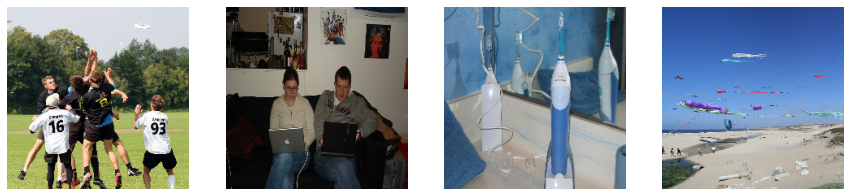

In [ ]:
#Take the first 4 images
plot_images_grid(next(iter(loader.dataset.take(1)))) 

What is needed now is the style image where the style will be imported from.

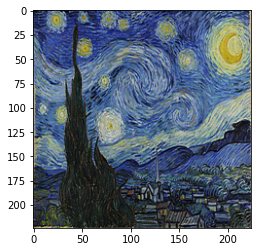

In [ ]:
# setting up style image
url="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
#url="https://www.tigf.it/wp-content/uploads/2021/02/Urlo-Munch-751x1024-1.jpg"
#url="https://t5e7g6y4.stackpathcdn.com/wp-content/uploads/2019/02/vincent-va-gogh-camera-da-letto-arles-1889-1.jpg"
style_image=load_url_image(url,dim=(input_shape[0],input_shape[1]),resize=True)
style_image=style_image/255.0

show_image(style_image)

Extract feature maps of style using the loss model:

In [ ]:
style_image=style_image.astype(np.float32)
style_image_batch=np.repeat([style_image],batch_size,axis=0)

style_activations=loss_model.get_activations(style_image_batch)["style"]

#Split the dataset
Split the dataset in order to make the model easier.

In [ ]:
train_size=int(0.2*len(loader))
test_size=int(0.1*len(loader))

print(f"train_size {train_size}")
print(f"test_size {test_size}")
train_dataset=loader.dataset.take(train_size)
test_dataset = loader.dataset.skip(train_size)
test_dataset=loader.dataset.take(test_size)

train_size 16556
test_size 8278


##Compute training


In [ ]:
#These hyperparameters can be tuned to change strength of style and content in output image 
content_weight=1e1
style_weight=1e6
total_variation_weight=0.002
content_layers_weights=[1]
style_layers_weights=[1] * 5

#Number of epochs
epochs=3

images_num=len(loader)
steps_per_epochs=images_num//batch_size
steps_per_epochs_train=train_size//batch_size
steps_per_epochs_test=test_size//batch_size
print(steps_per_epochs)
print(f"train_steps_per_epoch {steps_per_epochs_train}")
print(f"test_steps_per_epoch {steps_per_epochs_test}")


20695
train_steps_per_epoch 4139
test_steps_per_epoch 2069


Use Google Drive in order to save weights and to create checkpoints for resuming training instead of training from scratch.

In [ ]:
model_save_path="../gdrive/My Drive"
top_folder_name="scream"
save_path=os.path.join(model_save_path,top_folder_name)
print(save_path)

../gdrive/My Drive/scream


In [ ]:
os.makedirs(os.path.join(model_save_path,top_folder_name),exist_ok=True)

Enable mixed precision training because it offers significant computational speedup by performing operations in half-precision format.

In [ ]:
try:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy) 
except:
    pass

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
if os.path.isfile(os.path.join(save_path, "model_checkpoint.ckpt7.index")):
    style_model.load_weights(os.path.join(save_path, "model_checkpoint.ckpt7"))
    print("resuming training ...")
else:
    print("training scratch ...")

training scratch ...


Finally start training model. At each epoch the function `training_loop` is called, which runs till the number of steps per epochs defined.

In [ ]:
epoch_losses=[]
for epoch in range(1,epochs+1):
    print(f"epoch: {epoch}")
    batch_loss=training_loop(train_dataset,style_activations,steps_per_epochs_train,style_model,loss_model,optimizer,save_path,content_weight,
        style_weight,
        total_variation_weight,
        content_layers_weights,
        style_layers_weights)
    style_model.save_weights(os.path.join(save_path,"model_checkpoint.ckpt7"))
    print("Model Checkpointed at: ",os.path.join(save_path,"model_checkpoint.ckpt7"))
    print(f"loss: {batch_loss.numpy()}")
    epoch_losses.append(batch_loss)

After computing the training, plot the loss with respect to epochs in order to check loss summary:

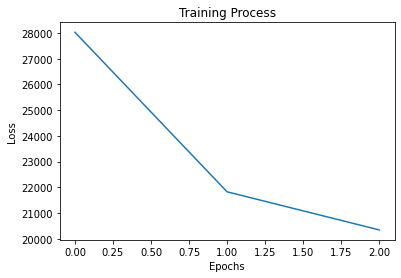

In [ ]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()


#Testing
Now it's time to test the network and generate some style images.



Begin by loading the weights from the model checkpoint.

In [ ]:
if os.path.isfile(os.path.join(save_path, "model_checkpoint.ckpt7.index")):
    style_model.load_weights(os.path.join(save_path, "model_checkpoint.ckpt7"))
    print("loading weights ...")
else:
    print("no weights found ...")

loading weights ...


Then load the image in which the style should be transferred.

In [ ]:
test_image_url="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/chicago-skyline-on-a-clear-day-royalty-free-image-115891582-1557159569.jpg"
test_image=load_url_image(test_image_url,dim=(640,480))
#test_iamge_path="/gdrive/MyDrive/StyleCLIP/IMG_9068.JPG"
#test_image=load_path_image(test_iamge_path,dim=(640,480))
test_image=np.expand_dims(test_image,axis=0)

test_image=test_image.astype(np.float32)

Compute the styled image in a forward pass:

In [ ]:
predicted_image=style_model(test_image)
predicted_image=np.clip(predicted_image,0,255)
predicted_image=predicted_image.astype(np.uint8)

test_output=test_image.astype(np.uint8)
test_output=tf.squeeze(test_output).numpy()
predicted_output=tf.squeeze(predicted_image).numpy()

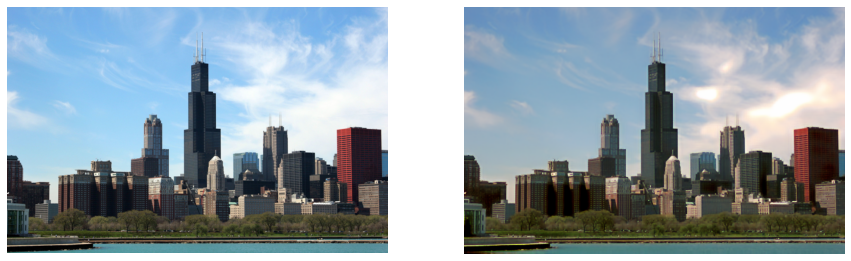

In [ ]:
#Plot the result
plot_images_grid([test_output,predicted_output])